In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


### Load Data

In [606]:
from transformers import DistilBertTokenizer, DistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [587]:
from transformers import AutoTokenizer, DistilBertForMaskedLM
import torch
from transformers import AutoConfig

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
config = AutoConfig.from_pretrained('distilbert-base-uncased')
untrained_model = DistilBertForMaskedLM(config=config)
model = DistilBertForMaskedLM.from_pretrained("distilbert-base-uncased")

inputs = tokenizer("The capital of France is [MASK].", return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# retrieve index of [MASK]
mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

predicted_token_id = logits[0, mask_token_index].argmax(axis=-1)

labels = tokenizer("The capital of France is Paris.", return_tensors="pt")["input_ids"]
# mask labels of non-[MASK] tokens
labels = torch.where(inputs.input_ids == tokenizer.mask_token_id, labels, -100)

outputs = model(**inputs, labels=labels)

In [628]:
weights_list = []
model.eval()
for p in model.named_parameters():
    weights_list.extend(p[1].view(-1).cpu().detach().numpy())

untrained_weights_list = []
untrained_model.eval()
for p in untrained_model.named_parameters():
    untrained_weights_list.extend(p[1].view(-1).cpu().detach().numpy())

In [629]:
weights_list = np.array(weights_list)
untrained_weights_list = np.array(untrained_weights_list)

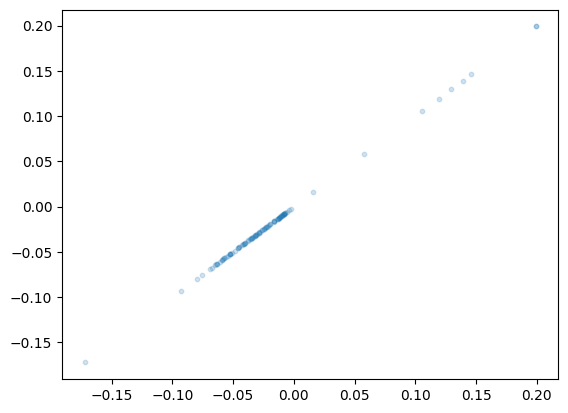

: 

In [630]:
random_idx = np.random.choice(list(range(1000)), 100)
plt.scatter(weights_list[random_idx], weights_list[random_idx], s=10, alpha=0.2)

In [311]:
from ucimlrepo import fetch_ucirepo 

wine_quality = fetch_ucirepo(id=186) 

X = wine_quality.data.features 
y = wine_quality.data.targets
y = pd.get_dummies(y["quality"])
  
# # metadata 
# print(wine_quality.metadata) 
  
# # variable information 
# print(wine_quality.variables) 


### Simple FNN and Dataloader

In [508]:
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
class MyDataset(Dataset):
    def __init__(self, data, xcols, ycols):
        self.data = data
        self.xcols = xcols
        self.ycols = ycols
        #self.data = pd.read_csv(csv_file).sample(n)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx): 
        x = torch.tensor(self.data.iloc[idx][self.xcols], dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx][self.ycols].values.astype('int64'), dtype=torch.float32)
        return x, y

class Brain(nn.Module):
    def __init__(self, input_size=16, output_size=4, hidden_dim=20, num_layers=3, device='cpu'):
        super(Brain, self).__init__()

        self.device = device
        self.score = []
        self.num_layers = num_layers
        self.loss_history = []

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_dim).to(device))  # Input layer
        self.layers.append(nn.BatchNorm1d(hidden_dim).to(device))  # Batch Normalization layer
        for _ in range(num_layers - 2):  # Hidden layers
            self.layers.append(nn.Linear(hidden_dim, hidden_dim).to(device))
            self.layers.append(nn.BatchNorm1d(hidden_dim).to(device))  # Batch Normalization layer
        self.layers.append(nn.Linear(hidden_dim, output_size).to(device))  # Output layer


        self.pretrained_weights_list = self.get_param_list()
        self.pretrained_weights_dict= self.get_param_dict()

    def forward(self, x):
        x = x.to(self.device)
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if i % 2 == 0:  # Apply ReLU after Linear layer and before BatchNorm layer
                x = torch.relu(x)
        x = self.layers[-1](x)  # No activation on the output layer
        return x 

    
    def track_forward(self, x):
        x_track = []
        w_track = []

        x = x.to(self.device)
        x_track.append(x.cpu().detach().numpy())

        for i, layer in enumerate(self.layers[:-1]):

            x = layer(x)
            if i % 2 == 0:  # Apply ReLU after Linear layer and before BatchNorm layer
                x = torch.relu(x)
                w_track.append(layer.weight.cpu().detach().numpy())
            else:
                x_track.append(x.cpu().detach().numpy())
                
        x = self.layers[-1](x)
        # x = torch.nn.functional.softmax(self.layers[-1](x), dim=0)  # No activation on the output layer
        x_track.append(x.cpu().detach().numpy())
        w_track.append(self.layers[-1].weight.cpu().detach().numpy())

        return x_track, w_track

    def get_param_list(self):
        """
        All weights as numpy array
        """
        params = []
        for i, p in enumerate(self.named_parameters()):
            params.extend(p[1].view(-1).cpu().detach().numpy())
        return np.array(params)

    def get_param_dict(self):
        """
        weights by layer as dictionary
        """
        params = {}
        for i, p in enumerate(self.named_parameters()):
            temp = torch.clone(p[1])
            params[p[0]] = temp
        return params


def train(model, dataloader, optimizer, criterion, epochs, gamma=1):
    for epoch in tqdm(range(epochs)):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            targets = targets.to(model.device)
            loss = criterion(outputs, targets)
            model.loss_history.append(loss.item())
            loss.backward()
            optimizer.step()

def evaluate(model, dataloader, criterion, plot=True):
    model.eval()  # Set the network to evaluation mode
    predictions = []
    targets = []
    losses = []
    with torch.no_grad():  # No need to calculate gradients
        for inputs, target in dataloader:
            output = model(inputs)
            if model.device.type == 'cuda':
                output = output.cpu()

            loss = criterion(output, target).item()
            losses.append(loss)
            preds = 3 + output.argmax(dim=1)
            predictions.extend(preds.numpy())
            
            target = np.array(3 + pd.from_dummies(pd.DataFrame(target))).squeeze()
            targets.extend(target)
            
    predictions = np.array(predictions)
    targets = np.array(targets)
    percent_correct = 100 * np.mean(predictions == targets)
    mean_loss = np.mean(losses)

    if plot:
        plt.hist(targets, alpha=0.3, density=True)
        plt.hist(predictions, alpha=0.3, density=True)
        plt.legend(labels=["Actual", "Predicted"])
        plt.ylabel("Density")
        plt.xlabel("Value")
        plt.title(f"Mean {str(criterion)} : {round(mean_loss, 4)}, Correct Predictions: {round(percent_correct, 2)}%")
        plt.show()


    return predictions, targets, mean_loss, percent_correct

    

In [523]:
from sklearn.model_selection import train_test_split
seed = 4746
set_seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

train_data = pd.concat([X_train, y_train], axis=1)
train_dataset = MyDataset(train_data, train_data.columns[:-7], train_data.columns[-7:])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_data = pd.concat([X_test, y_test], axis=1)
test_dataset = MyDataset(test_data, test_data.columns[:-7], test_data.columns[-7:])
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

### Initiate Model

In [524]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Brain(input_size=11, output_size=7, num_layers=3, hidden_dim=30, device=device)

#### Train Model

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\kathe\AppData\Local\Temp\ipykernel_39488\2880732725.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = torch.tensor(self.data.iloc[idx][self.xcols], dtype=torch.float32)
100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


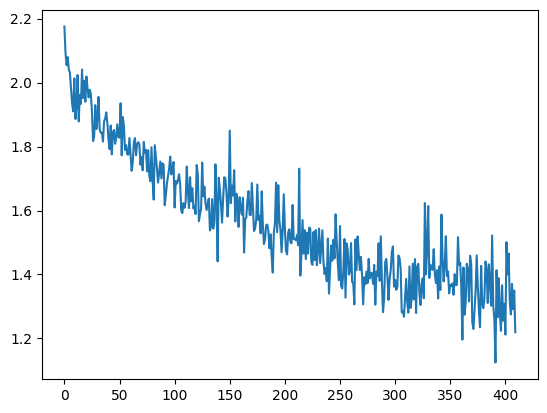

In [525]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss() #nn.MSELoss()
train(model, train_dataloader, optimizer, criterion, epochs=5)
torch.save(model.state_dict(), 'wine_model_SGD.pth')
plt.plot(range(len(model.loss_history)), model.loss_history)


C:\Users\kathe\AppData\Local\Temp\ipykernel_39488\2880732725.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = torch.tensor(self.data.iloc[idx][self.xcols], dtype=torch.float32)
C:\Users\kathe\AppData\Local\Temp\ipykernel_39488\2880732725.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = torch.tensor(self.data.iloc[idx][self.xcols], dtype=torch.float32)
C:\Users\kathe\AppData\Local\Temp\ipykernel_39488\2880732725.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To ac

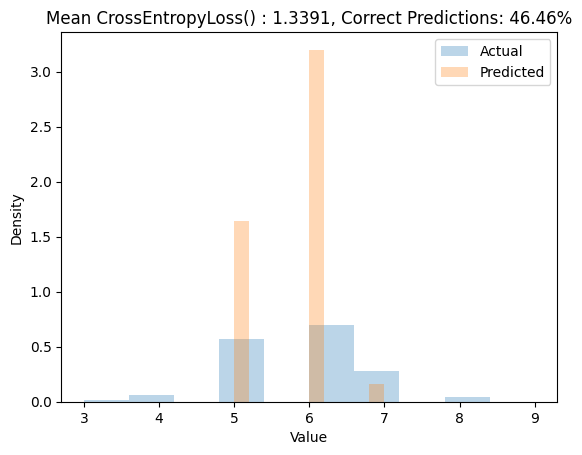

In [526]:
preds, targets, mean_loss, percent_correct = evaluate(model, test_dataloader, criterion, True)

### Analyze Weights

In [527]:
pretrained_weights = model.pretrained_weights_list
fine_tuned_weights = model.get_param_list()

diff = fine_tuned_weights - pretrained_weights

# want weights whose movement was in direction of sign of pretrained weight
score = diff * np.sign(pretrained_weights) # should be positive
threshold = np.quantile(score, 0.5)
mask = score > threshold

print(f"{100*round(1 - np.mean(mask), 4)}% of weights pruned")

57.410000000000004% of weights pruned


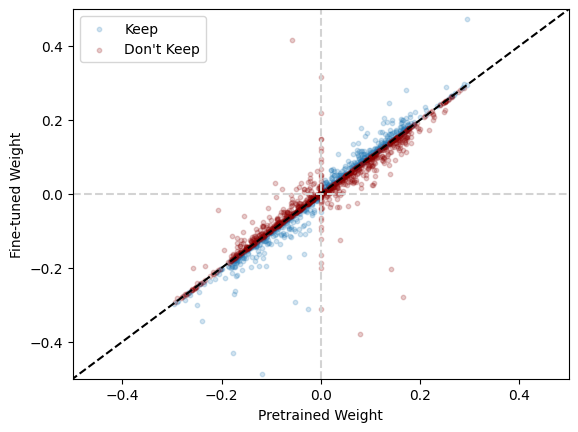

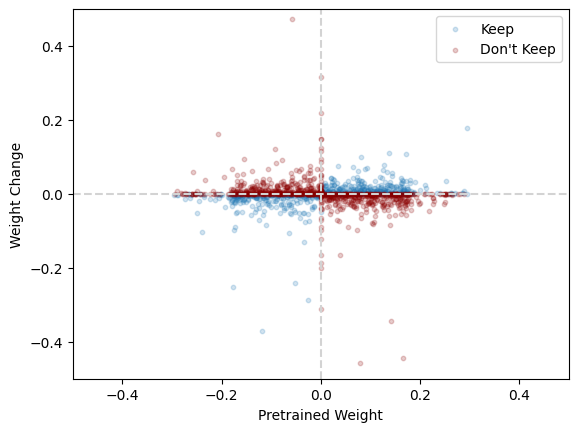

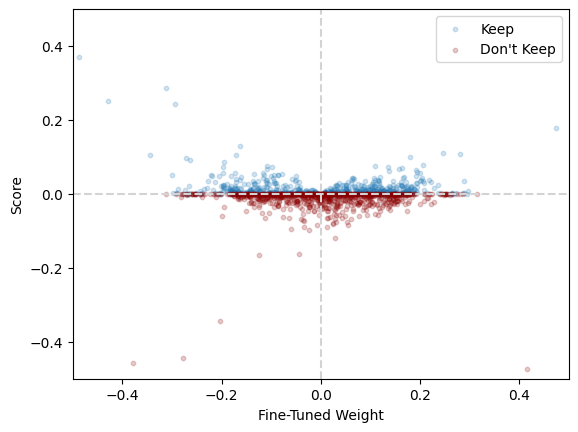

In [528]:
def plot_weights(pretrained_weights, fine_tuned_weights, mask):
    plt.scatter(pretrained_weights[mask], fine_tuned_weights[mask], alpha=0.2, s=10)
    plt.scatter(pretrained_weights[~mask], fine_tuned_weights[~mask], alpha=0.2, color="darkred", s=10)

    plt.plot([-1,1], [-1,1], linestyle="--", color="black")
    plt.axvline(x=0, color='lightgrey', linestyle='--')
    plt.axhline(y=0, color='lightgrey', linestyle='--')
    plt.xlabel("Pretrained Weight")
    plt.ylabel("Fine-tuned Weight")
    plt.legend(labels = ["Keep", "Don't Keep"])
    plt.ylim((-0.5, 0.5))
    plt.xlim((-0.5, 0.5))
    plt.show()

def plot_weight_vs_gradients(pretrained_weights, diff, mask):
    plt.scatter(pretrained_weights[mask], diff[mask], alpha=0.2, s=10)
    plt.scatter(pretrained_weights[~mask], diff[~mask], alpha=0.2, color="darkred", s=10)

    plt.axvline(x=0, color='lightgrey', linestyle='--')
    plt.axhline(y=0, color='lightgrey', linestyle='--')
    plt.xlabel("Pretrained Weight")
    plt.ylabel("Weight Change")
    plt.legend(labels = ["Keep", "Don't Keep"])
    plt.ylim((-0.5, 0.5))
    plt.xlim((-0.5, 0.5))
    plt.show()

def plot_weight_vs_scores(fine_tuned_weights, scores, mask):
    plt.scatter(fine_tuned_weights[mask], scores[mask], alpha=0.2, s=10)
    plt.scatter(fine_tuned_weights[~mask], scores[~mask], alpha=0.2, color="darkred", s=10)

    plt.axvline(x=0, color='lightgrey', linestyle='--')
    plt.axhline(y=0, color='lightgrey', linestyle='--')
    plt.xlabel("Fine-Tuned Weight")
    plt.ylabel("Score")
    plt.legend(labels = ["Keep", "Don't Keep"])
    plt.ylim((-0.5, 0.5))
    plt.xlim((-0.5, 0.5))
    plt.show()

plot_weights(pretrained_weights, fine_tuned_weights, mask)
plot_weight_vs_gradients(pretrained_weights, diff, mask)
plot_weight_vs_scores(fine_tuned_weights, score, mask)

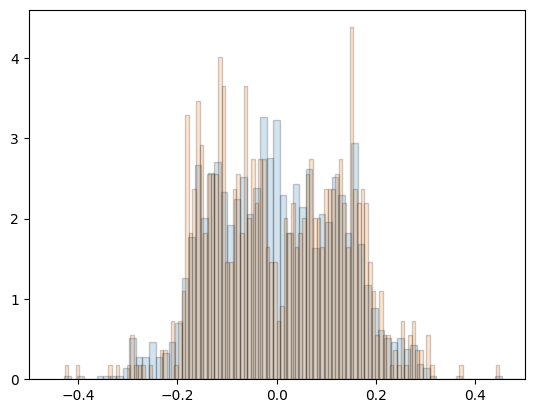

In [447]:
pruned_weights = fine_tuned_weights[mask]

plt.hist(fine_tuned_weights, bins=200, alpha=0.2, edgecolor="black", density=True)
plt.hist(pruned_weights, bins=200, alpha=0.2, edgecolor="black", density= True)
plt.xlim((-0.5, 0.5))
plt.show()

In [121]:
import seaborn as sns

<Axes: ylabel='Density'>

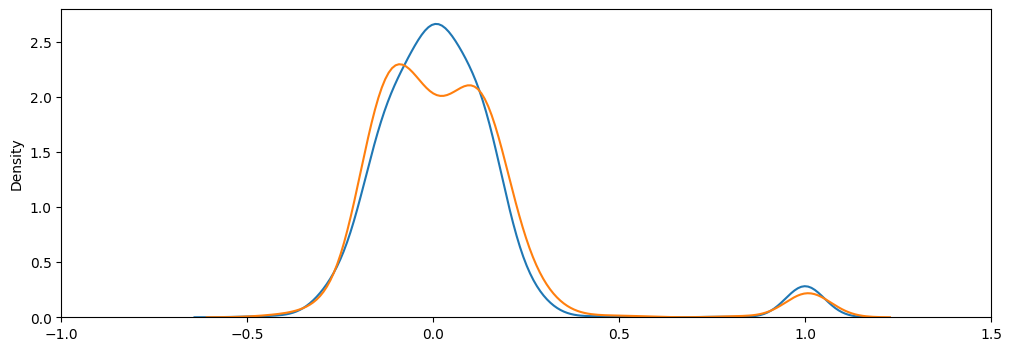

In [529]:
plt.figure(figsize=(12,4))
plt.xlim((-1, 1.5))
sns.kdeplot(fine_tuned_weights)
sns.kdeplot(pruned_weights)

### Determine and Apply Mask

In [533]:
def get_masked_model(model, q=0.1):

    pretrained_weights_dict = model.pretrained_weights_dict
    fine_tuned_weights_dict = model.get_param_dict()

    mask_dict = {}

    param_count = 0
    masked_param_count = 0
    for i, k in enumerate(pretrained_weights_dict.keys()):
        diff = fine_tuned_weights_dict[k] - pretrained_weights_dict[k]
        score = diff * torch.sign(pretrained_weights_dict[k])
        flat_score = score.flatten()
        threshold = torch.quantile(flat_score, q)
        mask = score > threshold
        mask_dict[k] = mask

        if i % 2 == 0: # weight
            model.layers[i//2].weight = nn.Parameter(mask*model.layers[i//2].weight)
        else: # bias
            model.layers[i//2].bias = nn.Parameter(mask*model.layers[i//2].bias)

        param_count += len(flat_score)
        masked_param_count += torch.sum(mask.flatten())
    
    percent_weight_removed = 1 - masked_param_count / param_count

    return model, percent_weight_removed.item()

masked_model = Brain(input_size=11, output_size=7, num_layers=3, hidden_dim=30, device=device)
masked_model.load_state_dict(torch.load('wine_model_SGD.pth'))
masked_model, percent_weight_removed = get_masked_model(masked_model, 0.1)

#### Check Masking

Text(0, 0.5, 'Masked Fine Tuned Weights')

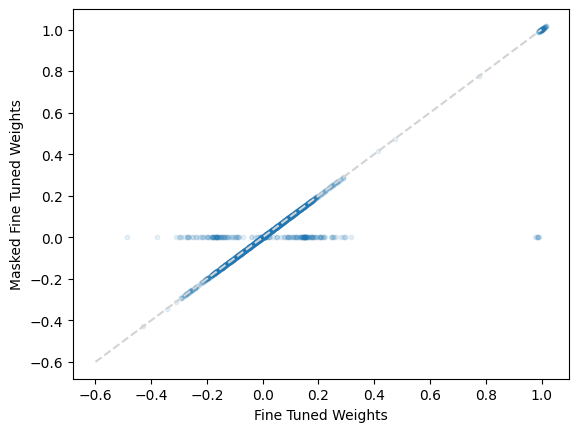

In [534]:
fine_tuned_weights = model.get_param_list()
masked_fine_tuned_weights = masked_model.get_param_list()

plt.scatter(fine_tuned_weights, masked_fine_tuned_weights, s=10, alpha=0.1)
plt.plot([-0.6,1], [-0.6,1], color="lightgrey", linestyle="dashed")
plt.xlabel("Fine Tuned Weights")
plt.ylabel("Masked Fine Tuned Weights")

### Check Performance of Masked Model

C:\Users\kathe\AppData\Local\Temp\ipykernel_39488\2880732725.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = torch.tensor(self.data.iloc[idx][self.xcols], dtype=torch.float32)
C:\Users\kathe\AppData\Local\Temp\ipykernel_39488\2880732725.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = torch.tensor(self.data.iloc[idx][self.xcols], dtype=torch.float32)
C:\Users\kathe\AppData\Local\Temp\ipykernel_39488\2880732725.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To ac

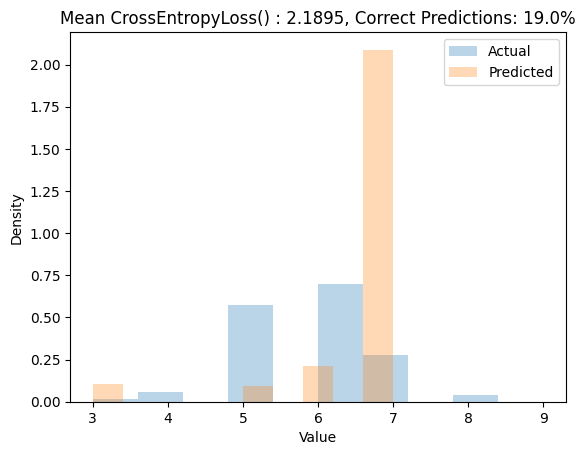

In [535]:
masked_preds, masked_targets, masked_mse, masked_percent_correct = evaluate(masked_model, test_dataloader, criterion, True)

#### Iterate Through Various Pruning Amounts

In [536]:
percent_weights_removed = []
masked_percents_correct = []

for q in tqdm(np.linspace(0, 1, 101)):

    masked_model = Brain(input_size=11, output_size=7, num_layers=3, hidden_dim=30, device=device)
    masked_model.load_state_dict(torch.load('wine_model_SGD.pth'))
    masked_model, percent_weight_removed = get_masked_model(masked_model, q)

    masked_preds, masked_targets, masked_mse, masked_percent_correct = evaluate(masked_model, test_dataloader, criterion, False)

    percent_weights_removed.append(percent_weight_removed)
    masked_percents_correct.append(masked_percent_correct)


  0%|          | 0/101 [00:00<?, ?it/s]C:\Users\kathe\AppData\Local\Temp\ipykernel_39488\2880732725.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = torch.tensor(self.data.iloc[idx][self.xcols], dtype=torch.float32)
C:\Users\kathe\AppData\Local\Temp\ipykernel_39488\2880732725.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = torch.tensor(self.data.iloc[idx][self.xcols], dtype=torch.float32)
C:\Users\kathe\AppData\Local\Temp\ipykernel_39488\2880732725.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

In [554]:
temp_df = pd.DataFrame({"percent_weights_removed": percent_weights_removed, "masked_percents_correct": masked_percents_correct, "optitmizer":"SGD", "seed":seed})
temp_df.to_csv("Pruning.csv")

Text(0, 0.5, '% Predictions Correct')

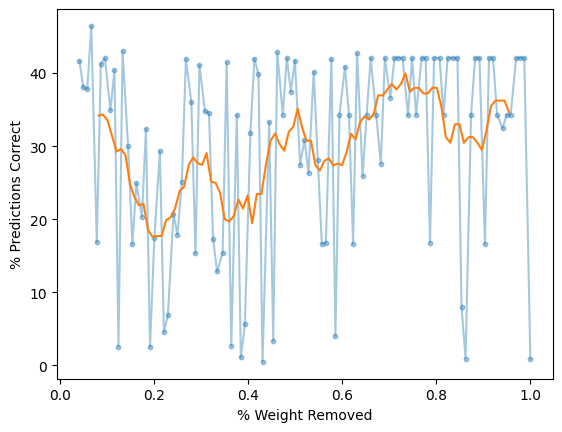

In [551]:
plt.plot(percent_weights_removed, masked_percents_correct, alpha=0.4)

window_size = 10
x_avg = pd.Series.rolling(pd.Series(percent_weights_removed), window=window_size).mean()
y_avg = pd.Series.rolling(pd.Series(masked_percents_correct), window=window_size).mean()
plt.plot(x_avg, y_avg)

plt.scatter(percent_weights_removed, masked_percents_correct, s=10, alpha=0.4)

plt.xlabel("% Weight Removed")
plt.ylabel("% Predictions Correct")

In [63]:
params = []
masks = []
gradient_list = []
scores_list = []
mask_list = []
for i, p in enumerate(model.named_parameters()):
    grad = grads[i]
    score = scores[i]
    param = p[1]
    print(i, p[0])
    q = torch.quantile(score, 1 - 0.7).item()
    print(q)
    temp_mask = score > q
    # temp_mask = ((param > 0) & (grad>0)) | ((param < 0) & (grad < 0))
    params.extend(param.view(-1).cpu().detach().numpy())
    gradient_list.extend(grad.view(-1).cpu().detach().numpy())
    mask_list.extend(temp_mask.view(-1).cpu().detach().numpy())
    scores_list.extend(score.view(-1).cpu().detach().numpy())
    masks.append(temp_mask)

params = np.array(params)
mask_list = np.array(mask_list)
gradient_list = np.array(gradient_list)
scores_list = np.array(scores_list)
keep = (mask_list*gradient_list) > 0
print(sum(keep))

0 layers.0.weight
-2.379280417130758e-08
1 layers.0.bias
-2.7643290810558515e-15
2 layers.1.weight
-0.00010462624049978331
3 layers.1.bias
1.6388500512221071e-07
4 layers.2.weight
-6.924488502590975e-07
5 layers.2.bias
-2.2941992483538343e-06
6 layers.3.weight
-3.717231084010564e-05
7 layers.3.bias
3.7992205761838704e-05
8 layers.4.weight
4.802412263416045e-07
9 layers.4.bias
0.0002632835821714252
479


In [65]:
len(scores_list)

1441

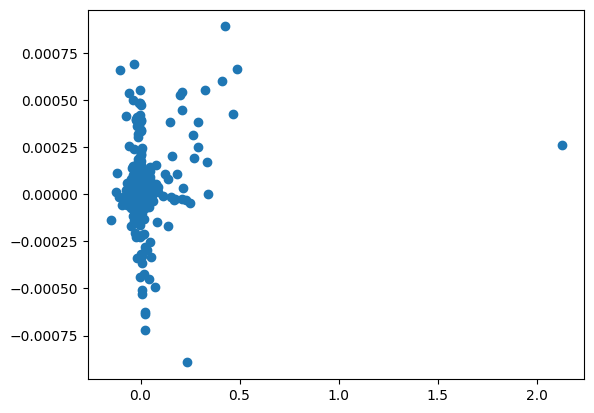

In [132]:
plt.scatter(diff * np.sign(pretrained_weights), scores_list)
# plt.plot([diff.min(), diff.max()],[diff.min(), diff.max()])

In [68]:
diff

array([-4.8840910e-02, -6.0399100e-03,  9.5066428e-04, ...,
       -2.1021649e-01,  6.5439105e-02,  2.1264043e+00], dtype=float32)

In [69]:
gradient_list

array([ 1.1912425e-02,  1.4731364e-03, -2.3187694e-04, ...,
        5.1272292e-02, -1.5960755e-02, -5.1863557e-01], dtype=float32)

In [249]:
np.unique(mask_list, return_counts=True)

(array([False,  True]), array([ 433, 1008], dtype=int64))

In [236]:
sum(mask_list*gradient_list != 0)

1074

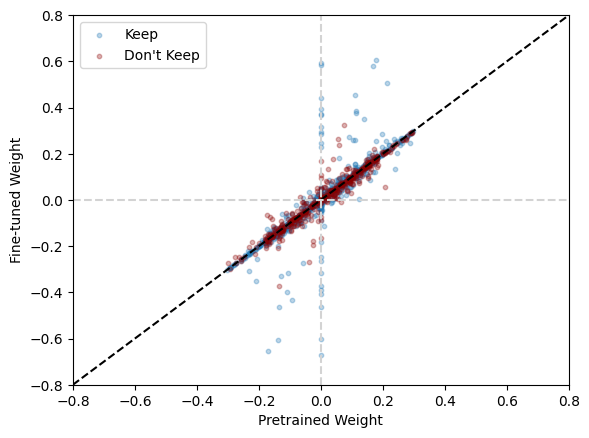

In [50]:
pretrained_weights= np.array(pretrained_weights)
plt.scatter(pretrained_weights[mask_list], params[mask_list], alpha=0.3, s=10)
plt.scatter(pretrained_weights[~mask_list], params[~mask_list], alpha=0.3, color="darkred", s=10)
plt.plot([-1,1], [-1,1], linestyle="--", color="black")
plt.axvline(x=0, color='lightgrey', linestyle='--')
plt.axhline(y=0, color='lightgrey', linestyle='--')
plt.xlabel("Pretrained Weight")
plt.ylabel("Fine-tuned Weight")
plt.legend(labels = ["Keep", "Don't Keep"])
plt.ylim(-0.8, 0.8)
plt.xlim(-0.8, 0.8)
plt.show()

In [264]:
len(params)

1441

(-0.0008, 0.0008)

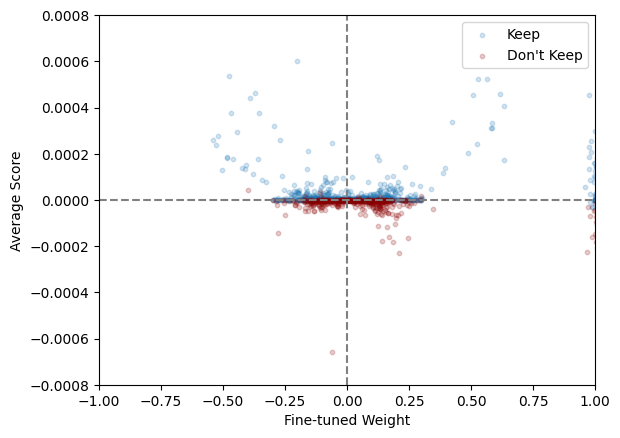

In [262]:
plt.scatter(params[mask_list], scores_list[mask_list], alpha=0.2, s=10)
plt.scatter(params[~mask_list], scores_list[~mask_list], alpha=0.2, color="darkred", s=10)
plt.axhline(y=0, color='grey', linestyle='--')
plt.axvline(x=0, color='grey', linestyle='--')
plt.xlabel("Fine-tuned Weight")
plt.ylabel("Average Score")
plt.legend(labels = ["Keep", "Don't Keep"])
plt.xlim(-1, 1)
plt.ylim(-0.0008, 0.0008)

(-0.2, 0.2)

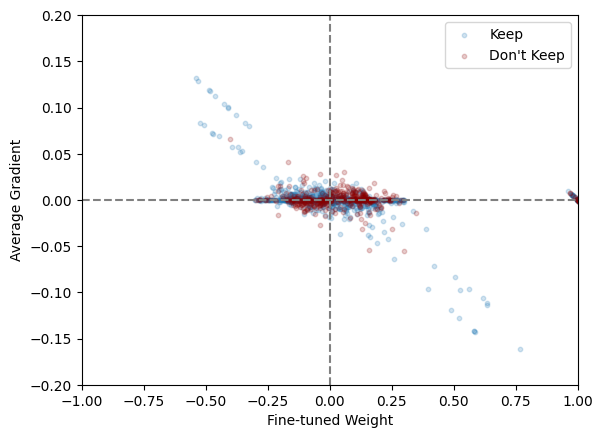

In [253]:
plt.scatter(params[mask_list], gradient_list[mask_list], alpha=0.2, s=10)
plt.scatter(params[~mask_list], gradient_list[~mask_list], alpha=0.2, color="darkred", s=10)
plt.axhline(y=0, color='grey', linestyle='--')
plt.axvline(x=0, color='grey', linestyle='--')
plt.xlabel("Fine-tuned Weight")
plt.ylabel("Average Gradient")
plt.legend(labels = ["Keep", "Don't Keep"])
plt.xlim(-1, 1)
plt.ylim(-0.2, 0.2)

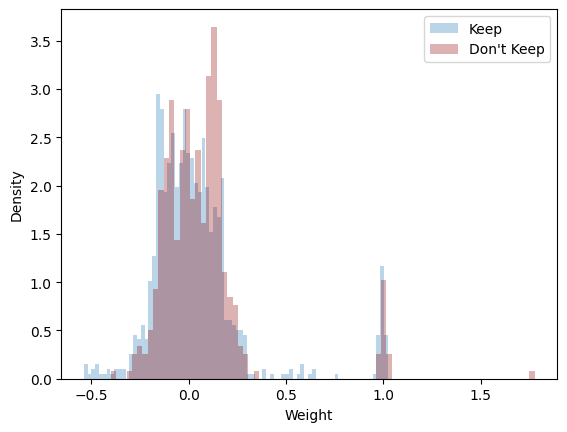

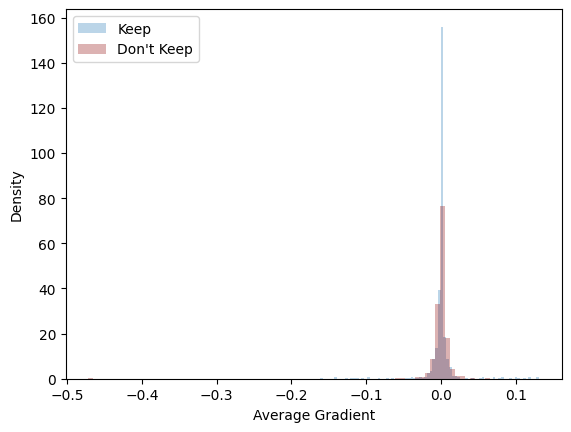

In [263]:
plt.hist(params[mask_list], bins=80, alpha=0.3, density=True)
plt.hist(params[~mask_list], bins=80, alpha=0.3, density=True, color="darkred")
plt.xlabel("Weight")
plt.ylabel("Density")
plt.legend(labels=["Keep", "Don't Keep"])
plt.show()

plt.hist(gradient_list[mask_list], bins=80, alpha=0.3, density=True)
plt.hist(gradient_list[~mask_list], bins=80, alpha=0.3, density=True, color="darkred")
plt.xlabel("Average Gradient")
plt.ylabel("Density")
plt.legend(labels=["Keep", "Don't Keep"])
plt.show()

### Create Masked / Pruned Model

In [251]:
import copy

In [116]:
masked_model = copy.deepcopy(model)
for i in range(int(len(masks)/2)):
    print("Weight:")
    print("original:", masked_model.layers[i].weight.shape)
    print("mask:", masks[i].shape)
    print("masked:", (masks[i]*masked_model.layers[i].weight).shape)
    print("-------------------------")
    print("Bias:")
    print("original:", masked_model.layers[i].bias.shape)
    print("mask:", masks[i+1].shape)
    print("masked:", (masks[i+1]*masked_model.layers[i].bias).shape)
    print("-------------------------")

    masked_model.layers[i].weight = nn.Parameter(masks[i]*masked_model.layers[i].weight)
    masked_model.layers[i].bias = nn.Parameter(masks[i+1]*masked_model.layers[i].bias)

torch.save(masked_model.state_dict(), 'pruned_wine_model.pth')

Weight:
torch.Size([30, 11])
torch.Size([30, 11])
torch.Size([30, 11])
-------------------------
Bias:
torch.Size([30])
torch.Size([30])
torch.Size([30])
-------------------------
Weight:
torch.Size([30])
torch.Size([30])
torch.Size([30])
-------------------------
Bias:
torch.Size([30])
torch.Size([30])
torch.Size([30])
-------------------------
Weight:
torch.Size([30, 30])
torch.Size([30])
torch.Size([30, 30])
-------------------------
Bias:
torch.Size([30])
torch.Size([30])
torch.Size([30])
-------------------------
Weight:
torch.Size([30])
torch.Size([30])
torch.Size([30])
-------------------------
Bias:
torch.Size([30])
torch.Size([30, 30])
torch.Size([30, 30])
-------------------------
Weight:
torch.Size([1, 30])
torch.Size([30, 30])
torch.Size([30, 30])
-------------------------
Bias:
torch.Size([1])
torch.Size([30])
torch.Size([30])
-------------------------


### Analyze Parameters

In [117]:
params = []
masked_params = []
for p in model.parameters():
    params.extend(p.view(-1).cpu().detach().numpy())
for p in masked_model.parameters():
    masked_params.extend(p.view(-1).cpu().detach().numpy())

masked_params = np.array(masked_params)
masked_params = masked_params[masked_params != 0]

params = np.array(params)
params = params[params != 0]

In [118]:
print(len(masked_params))
print(len(params))

2247
1441


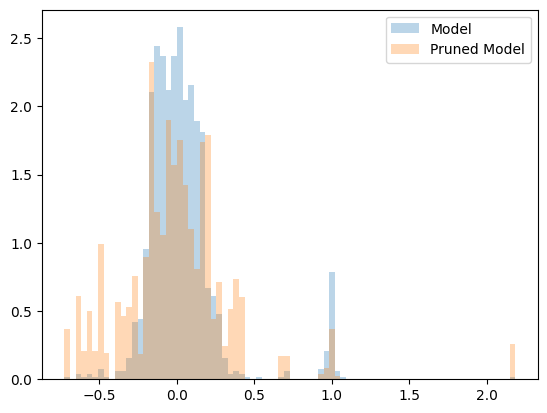

In [106]:
plt.hist(params, bins=80, alpha=0.3, density=True)
plt.hist(masked_params, bins=80, alpha=0.3, density=True)
plt.legend(labels=["Model", "Pruned Model"])
plt.show()

Text(0, 0.5, 'Average Gradient')

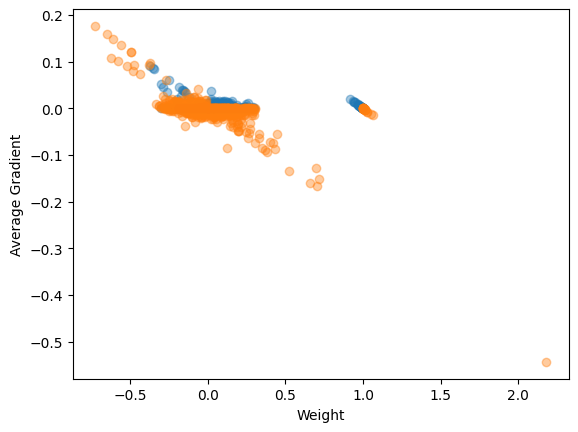

In [107]:
plt.scatter(params[keep], gradient_list[keep], alpha=0.4)
plt.scatter(params[~keep], gradient_list[~keep], alpha=0.4)
plt.xlabel("Weight")
plt.ylabel("Average Gradient")

In [450]:
params = np.array(params)
gradient_list = np.array(gradient_list)
keep = ((params > 0) & (gradient_list > 0)) | ((params < 0) & (gradient_list < 0))

In [454]:
len(params[~keep]) + len(params[keep])

1441

Text(0, 0.5, 'Average Gradient')

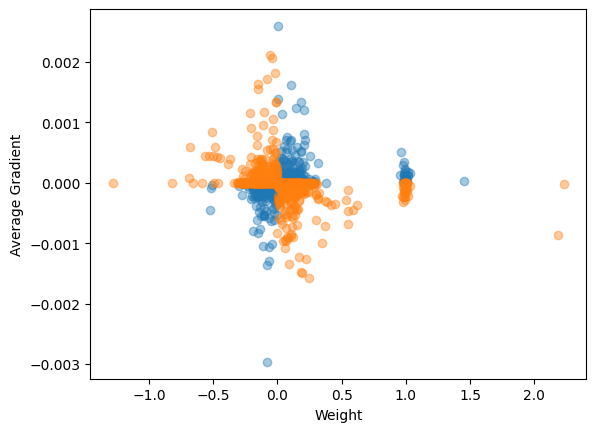

In [451]:

plt.scatter(params[keep], gradient_list[keep], alpha=0.4)
plt.scatter(params[~keep], gradient_list[~keep], alpha=0.4)
plt.xlabel("Weight")
plt.ylabel("Average Gradient")

### Analyze Model Performance

In [32]:
((targets - predictions)**2).mean()

1.308859787190172

In [458]:
# Assuming test_dataset is your testing dataset
test_dataloader = DataLoader(dataset, batch_size=32)

# Get the predictions
masked_model.eval()  # Set the network to evaluation mode
predictors = []
predictions = []
targets = []
with torch.no_grad():  # No need to calculate gradients
    for inputs, target in test_dataloader:
        output = masked_model(inputs)
        if masked_model.device.type == 'cuda':
            output = output.cpu()
        predictors.extend(inputs.numpy())
        predictions.extend(output.numpy())
        targets.extend(target.numpy())

predictors = np.array(predictors)
predictions = np.array(predictions)
targets = np.array(targets)



C:\Users\kathe\AppData\Local\Temp\ipykernel_228\384858945.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = torch.tensor(self.data.iloc[idx, :-1], dtype=torch.float32)
C:\Users\kathe\AppData\Local\Temp\ipykernel_228\384858945.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(self.data.iloc[idx, -1:], dtype=torch.float32)


RuntimeError: bias should contain 30 elements not 900

In [408]:
predictions

array([[3.290092 , 3.8672233, 2.9676309, ..., 3.2932968, 4.0485425,
        4.501098 ],
       [3.4972057, 4.5052156, 3.1727219, ..., 3.484981 , 4.294835 ,
        4.620574 ],
       [3.3208418, 4.2841716, 2.950595 , ..., 3.3042107, 4.2715917,
        4.547854 ],
       ...,
       [3.095991 , 3.6665022, 2.8591096, ..., 3.2524781, 4.0171947,
        4.274749 ],
       [3.3645797, 3.6548886, 3.0968614, ..., 3.456284 , 4.101331 ,
        4.3946133],
       [3.5232666, 4.1532135, 3.1177719, ..., 3.414372 , 4.2192693,
        4.6676598]], dtype=float32)

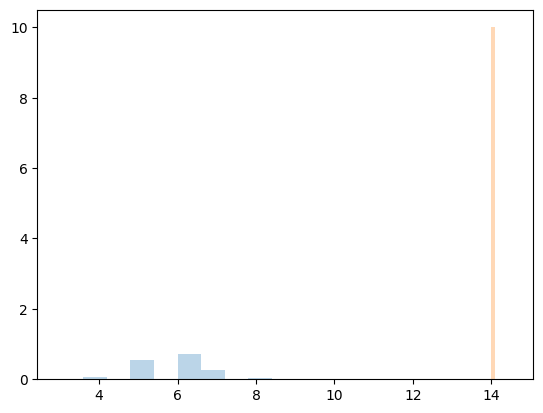

In [378]:
predictions = predictions.argmax(axis=1)
plt.hist(targets, alpha=0.3, density=True)
plt.hist(predictions, alpha=0.3, density=True)
plt.show()

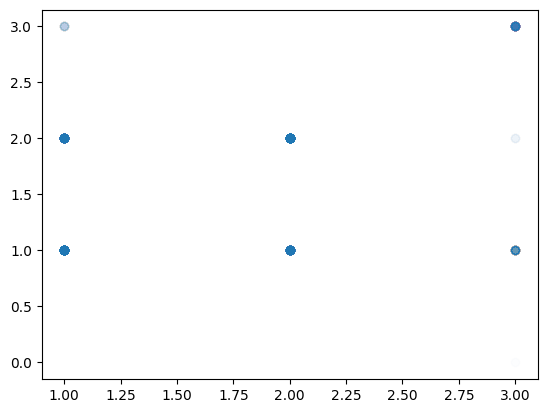

In [43]:
plt.scatter(predictions, targets, alpha=0.01)

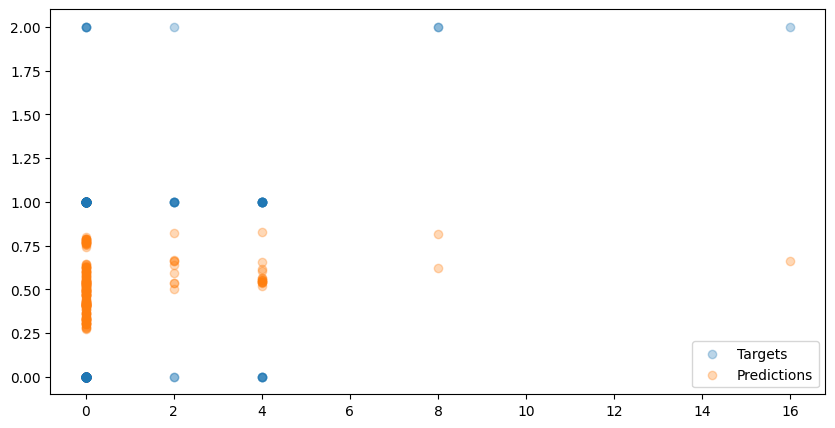

In [17]:
# Plot the targets and predictions
plt.figure(figsize=(10, 5))
plt.scatter(predictors[:, 2], targets[:, 0], label='Targets', alpha=0.3)
plt.scatter(predictors[:, 2], predictions[:, 0], label='Predictions', alpha=0.3)
plt.legend()
plt.show()

In [11]:
model.layers

ModuleList(
  (0): Linear(in_features=4, out_features=12, bias=True)
  (1-2): 2 x Linear(in_features=12, out_features=12, bias=True)
  (3): Linear(in_features=12, out_features=1, bias=True)
)

In [314]:
xcols = list(X_train.columns)

C:\Users\kathe\AppData\Local\Temp\ipykernel_228\3431531225.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = torch.tensor(self.data.iloc[idx, :-1], dtype=torch.float32)
C:\Users\kathe\AppData\Local\Temp\ipykernel_228\3431531225.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(self.data.iloc[idx, -1:], dtype=torch.float32)
C:\Users\kathe\AppData\Local\Temp\ipykernel_228\1236247223.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`

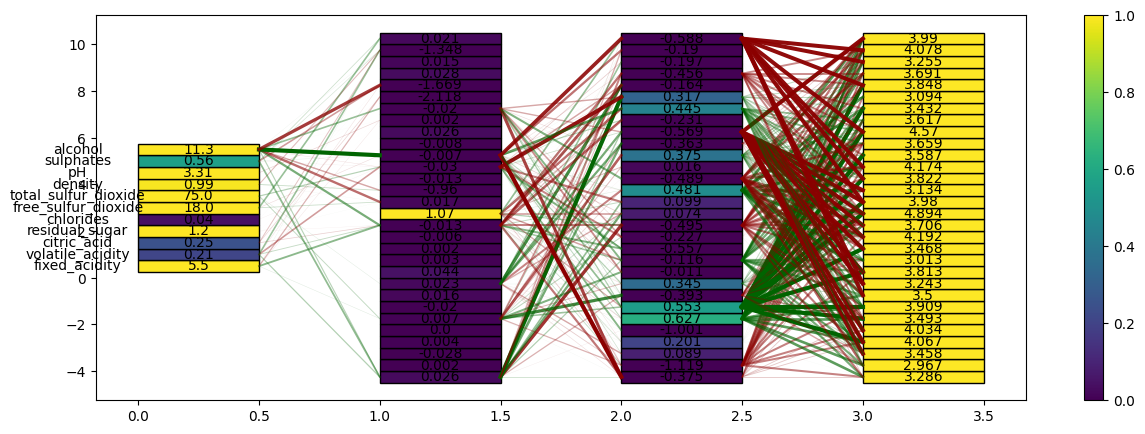

In [380]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import numpy as np

def visualize_pass(x, w, xcols, scale_factor=3, size=0.5, batch=True):
    fig, ax = plt.subplots(figsize=(15, 5))

    # Create a colormap
    cmap = cm.get_cmap('viridis')
    norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=True)
    sm = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

    n = len(x)
    for i in range(n): # iterate through layers
        if batch:
            batch_index = np.random.randint(len(x[i]))
            temp = x[i][batch_index]
        else:
            temp = x[i] # Node
        if i < n - 1: 
            weights = w[i] # Weights
            w_scaled = np.abs(weights**scale_factor)
            w_scaled =(w_scaled - w_scaled.min()) / (w_scaled.max() - w_scaled.min())
            #w_scaled = w_scaled**scale_factor

        for c in range(len(temp)): # iterate through columns
            # Map i to a color
            color = sm.to_rgba(temp[c])

            # Draw neurons
            y_coord = 3 + (c - len(temp) / 2) * size
            rect = patches.Rectangle((i, y_coord), size, size, linewidth=1, edgecolor='black', facecolor=color)
            ax.add_patch(rect)

            # Add the label
            ax.text(i+size/2, y_coord + size/2, str(round(temp[c],3)), ha='center', va='center', fontsize=20*size)

            if i==0:
                ax.text(i-size/2, y_coord + size/2, xcols[c], ha='center', va='center', fontsize=20*size)
            # Draw lines between every square pair in adjacent columns
            if i < n - 1: 
                if batch:
                    next_temp = x[i+1][batch_index]
                else:
                    next_temp = x[i+1]
                for next_c in range(len(np.log(next_temp))):
                    next_y_coord = 3 + (next_c - len(next_temp) / 2) * size
                    if (weights[next_c,c]>0): # positive weight -> green
                        ax.plot([i+size, i+1], [y_coord+size/2, next_y_coord+size/2], color='darkgreen', linewidth=3*w_scaled[next_c, c], alpha=w_scaled[next_c, c])
                    else: # negative weight -> red
                        ax.plot([i+size, i+1], [y_coord+size/2, next_y_coord+size/2], color='darkred', linewidth=3*w_scaled[next_c, c], alpha=w_scaled[next_c, c])
                    # ax.text(np.mean([i+size, i+1]), np.mean([y_coord+size/2, next_y_coord+size/2])+size/20, str(round(weights[next_c, c],3)), ha='center', va='center', fontsize=5)

    #plt.xlim(0, n)
    #plt.ylim(0, n+1)
    plt.colorbar(sm, ax=ax)
    plt.show()

for inputs, targets in dataloader:
    x_track, w = model.track_forward(inputs)
visualize_pass(x_track, w , xcols)


In [304]:
x_track[3][3]

array([4.8814206], dtype=float32)

C:\Users\kathe\AppData\Local\Temp\ipykernel_228\2005202370.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
C:\Users\kathe\AppData\Local\Temp\ipykernel_228\2005202370.py:39: RuntimeWarning: divide by zero encountered in log
  for next_c in range(len(np.log(next_temp))):


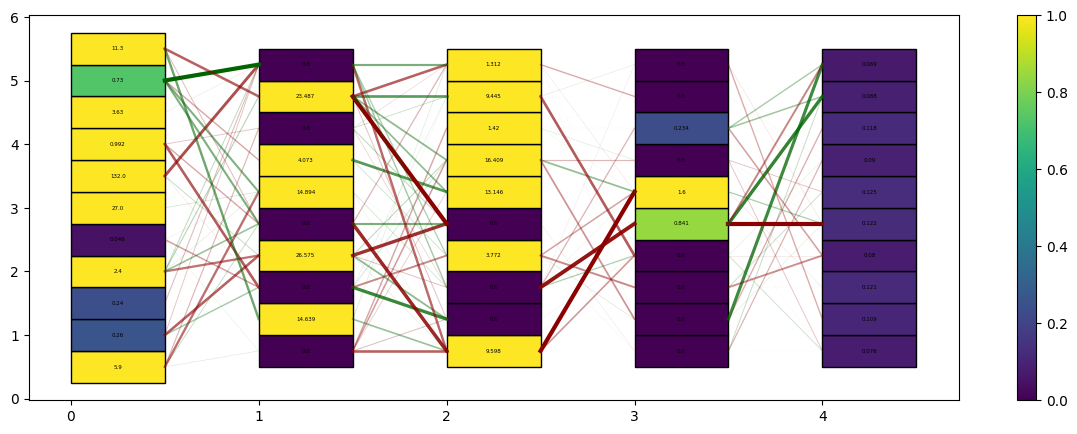

In [79]:
visualize_pass(x_track, w, 10)

In [46]:
w

[array([[-0.54309225, -0.0374287 ,  0.22130656,  0.53746766, -0.49834937,
          0.00373732,  0.40573356,  0.5004395 ,  0.05182342,  0.20063467,
          0.28436944,  0.23754063,  0.02013211,  0.0432233 , -0.04348825,
          0.17659838],
        [ 0.16497414,  0.16761768,  0.07788245, -0.1199444 ,  0.40453416,
         -0.21396887, -0.08530488, -0.17075561,  0.10720212,  0.17053561,
          0.07230671, -0.11311294,  0.02286535, -0.07441707, -0.19260183,
          0.1913119 ],
        [-0.02316947,  0.0963048 ,  0.1180876 , -0.11706586,  0.03458478,
          0.10613993,  0.13980125,  0.24876998, -0.00430316,  0.12508324,
          0.0170773 , -0.05368886, -0.20500095, -0.1412689 , -0.02187186,
         -0.00855705],
        [ 0.1988954 ,  0.19421002,  0.13533954,  0.22065918, -0.19183253,
          0.14818539,  0.05964287, -0.0568602 , -0.17399758,  0.07460622,
         -0.03840325,  0.09970459,  0.12461685, -0.0792649 , -0.25422555,
          0.1966522 ],
        [-0.14870673

In [172]:
model.layers[0].weight  + 0.48

tensor([[ 0.8322,  0.9462,  0.3746, -0.0048],
        [ 0.1299,  0.8494,  0.3964,  0.0593],
        [ 0.2598,  0.3020,  0.7178, -0.0621],
        [ 0.9777,  0.6939,  0.0776,  0.8650],
        [ 0.3152, -0.0156,  0.1115,  0.4778],
        [ 0.3599,  0.9609,  0.9429,  0.0096],
        [ 0.6470,  0.5442,  0.7056,  0.5722],
        [ 0.6161,  0.5547,  0.9437,  0.0425],
        [ 0.4196,  0.2060,  0.2116,  0.5169],
        [-0.0067,  0.7643,  0.0711,  0.1468],
        [ 0.3920,  0.8574,  0.9172,  0.5908],
        [ 0.3987,  0.3511,  0.4438,  0.1632]], grad_fn=<AddBackward0>)

In [191]:
w = []
for layer in model.layers:
    w.append(layer.weight.cpu().detach().numpy().flatten())
w = np.concatenate(w)

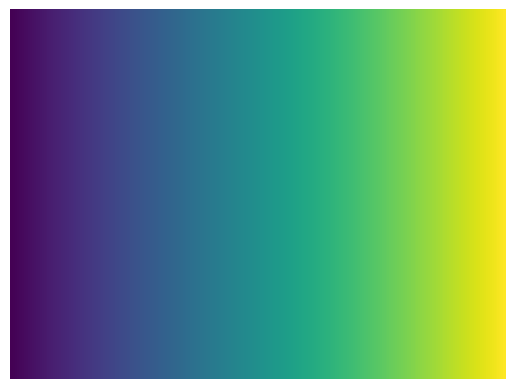

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def create_colormap_image(filename='colormap.png'):
    gradient = np.linspace(0, 1, 256)  # Gradient from 0 to 1
    gradient = np.vstack((gradient, gradient))  # Make it a 2D image

    fig, ax = plt.subplots()
    ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap('viridis'))
    plt.axis('off')

    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

create_colormap_image()
